<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/Demo_for_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setup

In [ ]:
import os
import datetime

#download yfinance package
!pip install yfinance
import yfinance as yf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False

#2 Data Mining / Web Scraping

## 2.1 BTC-USD dataset

This dataset contains...

In [ ]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*3)
symbol = 'BTC-USD'

cc_data = yf.download(symbol, start=start_date, end=today)
cc_data.reset_index(inplace=True,col_fill=('Date'))


In [ ]:
fig1, ax1 = plt.subplots()
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}$'))
ax1.plot(cc_data['Date'], cc_data['Close'],label = 'Close')
ax1.set_title((f'{symbol} from {start_date} to {today}'), fontsize = 12)
ax1.legend(fontsize=8)

# 3 Data Preprocessing

## 3.1 Feature Enigneering
....

## 3.2 Training, Validation, and Test Data Split

In [4]:
data = cc_data.loc[:,['Close']]

len_data = len(data)
train_data = data[0:int(len_data*0.7)] # 70%
val_data = data[int(len_data*0.7):int(len_data*0.9)] # 20%
test_data = data[int(len_data*0.9):] # 10%


## 3.3 Data Normalization


In [5]:
train_data_mean = train_data.mean()
train_data_std = train_data.std()

train_data = (train_data - train_data_mean) / train_data_std
val_data = (val_data - train_data_mean) / train_data_std
test_data = (test_data - train_data_mean) / train_data_std

## 3.4 Data Set Generator Pipeline

### 3.4.1 Window Generator

In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, label_columns=None):
    
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [8]:
def plot(self, model=None, plot_col='Close', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [9]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#4 Prediction Models


Compile and Fit function

In [11]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=20,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## 4.1 Univariate Input and Single Step Output Models

In [12]:
val_performance = {}
performance = {}

### 4.1.1 LSTM

#### 4.1.1.1 Model definition + compile and fit

In [ ]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1,
    train_df=train_data, val_df=val_data, test_df= test_data,
    label_columns=['Close'])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

#### 4.1.1.2 Model Performance + Plot

2/2 [==============================] - 0s 10ms/step - loss: 319.5062 - mean_absolute_error: 17.7290
{'LSTM': [319.5062255859375, 17.728986740112305]}
{'LSTM': [18.95083236694336, 2.7213048934936523]}


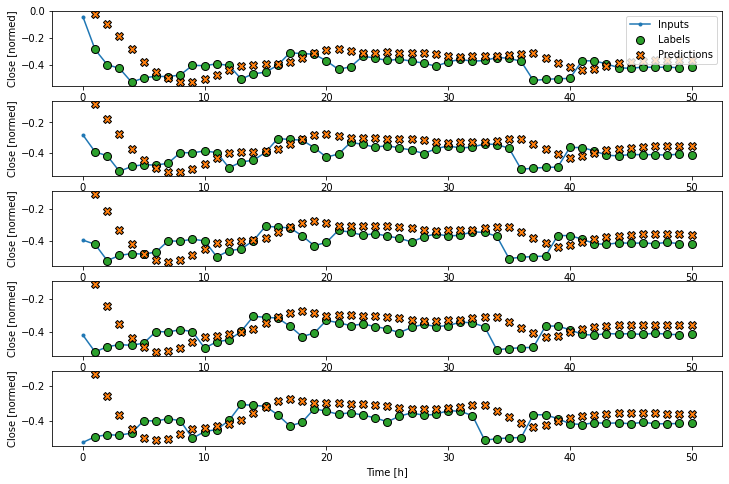

In [14]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM']= lstm_model.evaluate( wide_window.test)
print(performance)
print(val_performance)

wide_window.plot(lstm_model)

## 4.2 Univariate Input and Multi Step Output Models